In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.cluster import DBSCAN
import math
from shapely.ops import transform
from shapely.ops import cascaded_union
import pyproj
from functools import partial
from shapely.geometry import Point
import mplleaflet
import folium
from folium.vector_layers import Polygon
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_hour(ts):
    return ts.hour

In [3]:
def get_minute(ts):
    return ts.hour * 100 + int(ts.minute / 15) * 15

In [4]:
def load_day(day):
    header = ['timestamp', 'line_id', 'direction', 'jrny_patt_id', 'time_frame', 'journey_id', 'operator', 
              'congestion', 'lon', 'lat', 'delay', 'block_id', 'vehicle_id', 'stop_id', 'at_stop']
    types = {'timestamp': np.int64,
             'journey_id': np.int32,
             'congestion': np.int8,
             'lon': np.float64,
             'lat': np.float64,
             'delay': np.int8,
             'vehicle_id': np.int32,
             'at_stop': np.int8}
    file_name = 'data/siri.201301{0:02d}.csv'.format(day)
    df = pd.read_csv(file_name, header=None, names=header, dtype=types, parse_dates=['time_frame'], 
                     infer_datetime_format=True)
    null_replacements = {'line_id': 0, 'stop_id': 0}
    df = df.fillna(value=null_replacements)
    df['line_id'] = df['line_id'].astype(np.int32)
    df['stop_id'] = df['stop_id'].astype(np.int32)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
    df['hour'] = df['timestamp'].apply(get_hour)
    return df

In [5]:
def load_data():
    header = ['timestamp', 'line_id', 'direction', 'jrny_patt_id', 'time_frame', 'journey_id', 'operator', 
              'congestion', 'lon', 'lat', 'delay', 'block_id', 'vehicle_id', 'stop_id', 'at_stop']
    types = {'timestamp': np.int64,
             'journey_id': np.int32,
             'congestion': np.int8,
             'lon': np.float64,
             'lat': np.float64,
             'delay': np.int8,
             'vehicle_id': np.int32,
             'at_stop': np.int8}
    
    data = None
    
    for day in range(1, 32):
        file_name = 'data/siri.201301{0:02d}.csv'.format(day)
        df = pd.read_csv(file_name, header=None, names=header, dtype=types, parse_dates=['time_frame'], 
                         infer_datetime_format=True)
        
        if data is None:
            data = df
        else:
            data = data.append(df)
            
    null_replacements = {'line_id': 0, 'stop_id': 0}
    data = data.fillna(value=null_replacements)
    data['line_id'] = data['line_id'].astype(np.int32)
    data['stop_id'] = data['stop_id'].astype(np.int32)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='us')
    data['hour'] = data['timestamp'].apply(get_hour)
    data['minute'] = data['timestamp'].apply(get_minute)
    return data

In [6]:
def load_day_hour(day, hour):
    df = load_day(day)
    return df[df['hour'] == hour]

In [7]:
def create_radian_columns(df):
    df['rad_lng'] = np.radians(df['lon'].values)
    df['rad_lat'] = np.radians(df['lat'].values)
    return df

In [8]:
def density_cluster(df, eps_in_meters=50, num_samples=15):
    earth_perimeter = 40070000.0  # In meters
    eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)

    db_scan = DBSCAN(eps=eps_in_radians, min_samples=num_samples, metric='haversine',
                    algorithm='ball_tree')
    return db_scan.fit_predict(df[['rad_lat', 'rad_lng']])

In [9]:
def generate_blob_clusters(df, eps_in_meters=5):
    # Group the observations by cluster identifier
    groups = df.groupby('cluster')
    clusters = list()
    blobs = list()
    counts = list()

    for cluster_id, points in groups:
        if cluster_id >= 0:
            buffer_radius = eps_in_meters
            buffers = [buffer_in_meters(lon, lat, buffer_radius)
                       for lon, lat in zip(points['lon'], points['lat'])]
            blob = cascaded_union(buffers)
            blobs.append(blob)
            clusters.append(cluster_id)
            counts.append(len(points))

    # Create the GeoDataFrame from the cluster numbers and blobs
    data = {'cluster': clusters, 'polygon': blobs, 'count': counts}

    cluster_gdf = gpd.GeoDataFrame(pd.DataFrame(data), geometry='polygon')
    cluster_gdf.crs = {'init': 'epsg:4326'}
    return cluster_gdf

In [10]:
def buffer_in_meters(lng, lat, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')

    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)

    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)

    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [11]:
def parse_lon_lat(lon_lat):
    lon, lat = lon_lat.split(' ')
    return float(lat), float(lon)

In [12]:
def parse_polygon(polygon_wkt):
    idx = polygon_wkt.find('), (')
    if idx == -1:
        idx = -2
    items = polygon_wkt[10:idx].split(', ')
    try:
        locations = [parse_lon_lat(item) for item in items]
    except:
        print('Faulty Polygon:')
        print(polygon_wkt)
    return locations

In [13]:
def show_blob_map(df):
    map = folium.Map()
    
    polygons = []
    
    gdf = generate_blob_clusters(df)
    for index, row in gdf.iterrows():
        polygons.append(row['polygon'].wkt)
        locations = parse_polygon(row['polygon'].wkt)
        polygon = Polygon(locations, fill=True, opacity=0.6, color='#ff0000', 
                          fill_color='#ff0000', fill_opacity=0.6)
        polygon.add_to(map)
    
    return map, polygons

In [14]:
def save_polygons(polygons, time):
    file_name = 'maps/polygons_{0:04d}.csv'.format(time)
    with open(file_name, "w") as f:
        f.write('polygons\n')
        
        for p in polygons:
            f.write('\"{0}\"\n'.format(p))

In [15]:
data = load_data()

In [16]:
data = create_radian_columns(data)

In [17]:
congestion_points = []

for hour in range(24):
    for minute in range(0, 4):
        time = hour * 100 + minute * 15
        
#         print('Time : {0}'.format(time))
    
        df = data[data['minute'] == time]
        df = df[df['congestion'] == 1].copy()

        if len(df) > 0:
            df['cluster'] = density_cluster(df, eps_in_meters=5, num_samples=5)

            size = len(df[df['cluster'] >= 0])
            # print('Count: {0} / {1}'.format(len(df), size))
            congestion_points.append(size)
        else:
            congestion_points.append(0)

#             map, polygons = show_blob_map(df)
#             map.save('maps/congestion_{0:04d}.html'.format(time))
#             save_polygons(polygons, time)


In [18]:
chart = np.append(np.arange(24*4), np.array(congestion_points), axis=0) 
chart = chart.reshape((1,24*4*2))
chart = chart.reshape((2, 24*4))
chart

array([[    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9,    10,    11,    12,    13,    14,    15,    16,    17,
           18,    19,    20,    21,    22,    23,    24,    25,    26,
           27,    28,    29,    30,    31,    32,    33,    34,    35,
           36,    37,    38,    39,    40,    41,    42,    43,    44,
           45,    46,    47,    48,    49,    50,    51,    52,    53,
           54,    55,    56,    57,    58,    59,    60,    61,    62,
           63,    64,    65,    66,    67,    68,    69,    70,    71,
           72,    73,    74,    75,    76,    77,    78,    79,    80,
           81,    82,    83,    84,    85,    86,    87,    88,    89,
           90,    91,    92,    93,    94,    95],
       [  219,    99,    79,    65,    59,     0,    45,    44,    44,
           45,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   222,   745,  1397,
         3716,  7180,  847

In [19]:
chart_df = pd.DataFrame(data=np.transpose(chart), columns=['time', 'size'])

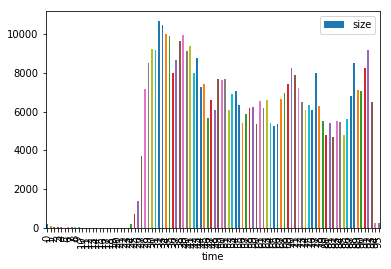